In [35]:
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble, execute
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import CXGate
from qiskit.dagcircuit import DAGOpNode
from qiskit.converters import circuit_to_dag, dag_to_circuit

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import copy

In [55]:
def grayvalue_to_angle(value):
    return value * pi/4

def grayscale_to_angles(image_mat):
    for i in range(len(image_mat)):
        for j in range(len(image_mat)):
            image_mat[i][j] = grayvalue_to_angle(image_mat[i][j])
    
    return image_mat

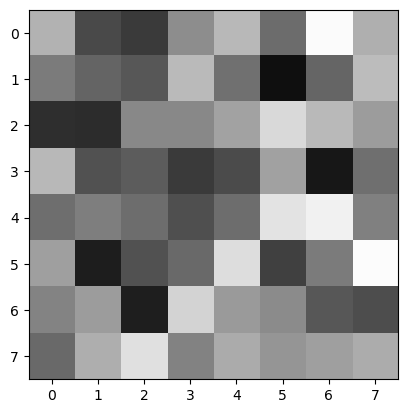

In [56]:
image = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0]
]).astype(float)

image = np.array([
        [1, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0]
]).astype(float)

np.random.seed(123)
rand_image = np.random.rand(8,8)
image = rand_image

image_angles = copy.deepcopy(image)
image_angles = grayscale_to_angles(image_angles)

max_intensity = max([val for row in image for val in row])

_ = plt.imshow(image, cmap='gray', vmin=0, vmax=1)

In [57]:
intensities = [i for image_row in image for i in image_row]
sqrt_intensities = [np.sqrt(i) for i in intensities]
scaled_intensities = [i*(1/np.sqrt(sum(intensities))) for i in sqrt_intensities]
# print(intensities)

In [58]:
qc_aux = QuantumCircuit(6)
qc_aux.initialize(scaled_intensities)
transpiled_circuit = transpile(qc_aux, basis_gates=['cx', 'id', 'rz', 'sx', 'x'], optimization_level=3)

backend = Aer.get_backend('unitary_simulator')
job = execute(transpiled_circuit, backend, shots=8192)
initial_state = UnitaryGate(job.result().get_unitary(qc_aux))

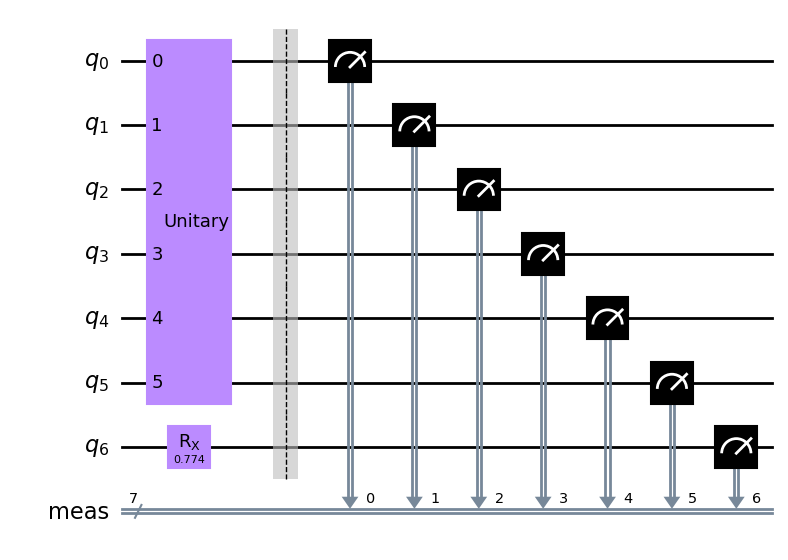

In [59]:
theta = grayvalue_to_angle(max_intensity)

qc = QuantumCircuit(7)

qc.append(initial_state, [i for i in range(6)])
qc.rx(theta, 6)
qc.measure_all()

qc.draw('mpl')

{'1110010': 10, '1011110': 14, '1001101': 11, '1100100': 70, '1000010': 38, '1101010': 45, '1110110': 45, '0001101': 47, '1111110': 83, '1000111': 84, '1001000': 64, '0010000': 176, '0011110': 69, '1001111': 93, '1010100': 84, '1100011': 49, '1101000': 83, '0000010': 196, '1101111': 141, '0011010': 289, '1101110': 77, '0110000': 444, '1110000': 79, '1000100': 119, '0111101': 503, '0100011': 248, '0110100': 507, '0001010': 297, '0100110': 825, '1111011': 64, '1010000': 30, '1111100': 83, '0010111': 506, '0100010': 366, '1011101': 74, '1000000': 94, '0001100': 364, '0001110': 334, '0101110': 429, '0111011': 448, '0111000': 375, '0101000': 533, '1100101': 130, '1101011': 62, '1110001': 99, '1111010': 126, '0101011': 391, '1101101': 33, '0111111': 579, '1010111': 73, '1100000': 67, '0100100': 346, '1100110': 141, '0001000': 429, '1101001': 19, '0111010': 708, '0111100': 610, '1111111': 80, '1110101': 79, '0011101': 527, '0010001': 164, '0110001': 471, '1000011': 78, '1011111': 64, '0000101

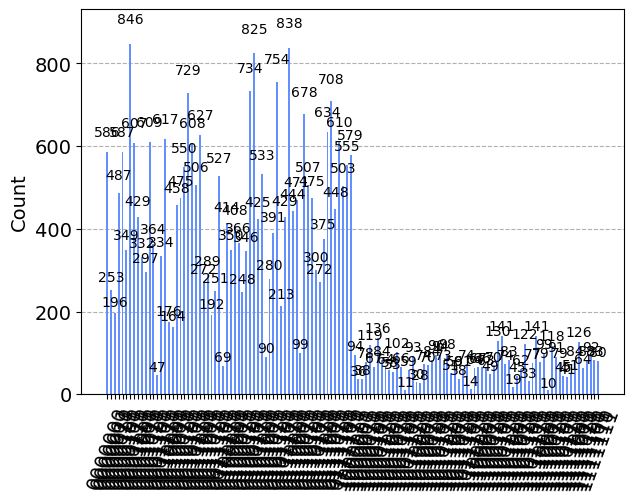

In [60]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
result = aer_sim.run(t_qc, shots=2**15).result()
counts = result.get_counts(qc)

print(counts)
plot_histogram(counts)

In [61]:
# Image reconstruction
rec_image = [[0 for _ in range(8)] for _ in range(8)]

pos_counts = {k[1:]:0 for k in counts.keys()}
max_intensity_counter = [0, 0]
for k in counts.keys():
    pos_counts[k[1:]] += counts[k]
    max_intensity_counter[int(k[0])] += counts[k]
    
highest_count = max(pos_counts.values())
max_intensity = max_intensity_counter[0]/sum(max_intensity_counter)
for k in pos_counts.keys():
    q1 = int(k[:3], 2)
    q2 = int(k[3:], 2)
    
    rec_image[q1][q2] = (pos_counts[k]/highest_count)*max_intensity

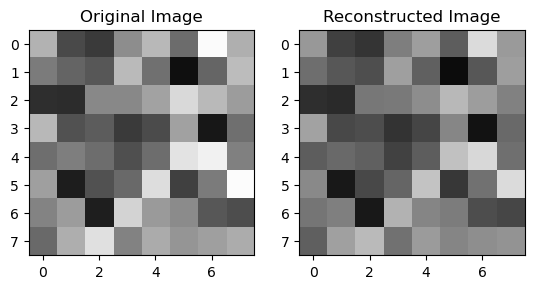

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

_ = ax1.imshow(image, cmap='gray', vmin=0, vmax=1)
_ = ax1.set_title('Original Image')

_ = ax2.imshow(rec_image, cmap='gray', vmin=0, vmax=1)
_ = ax2.set_title('Reconstructed Image')

In [63]:
image_diff = image - rec_image
squared_diff = 0
for i in range(len(image_diff)):
    for j in range(len(image_diff[i])):
        squared_diff += image_diff[i][j]**2

print('Squared error:', squared_diff)

Squared error: 0.36081524880211985
